In [1]:
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import hdf5getters as GETTERS
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.35:7077") \
        .appName("analysis")\
        .config("spark.executor.memory", "1g")\
        .config("spark.executor.cores",2)\
        .config("spark.dynamicAllocation.enabled", False) \
        .config("spark.shuffle.service.enabled", False) \
        .getOrCreate()
        
sc = spark_session.sparkContext

In [2]:
import io
import h5py
import math
import attr

def get_year(h5):
    return int(h5["musicbrainz"]["songs"][0][1])

def get_artist_hotness(h5):
    x = float(h5["metadata"]["songs"][0][3])
    if math.isnan(x):
        return 0.0
    else:
        return x
def get_song_hotness(h5):
    x =  float(h5["metadata"]["songs"][0][16])
    if math.isnan(x):
        return 0.0
    else:
        return x
def get_loudness(h5):
    x = float(h5["analysis"]["songs"][0][23])
    if math.isnan(x):
        return 0.0
    else:
        return x
def get_tempo(h5):
    x = float(h5["analysis"]["songs"][0][27])
    if math.isnan(x):
        return 0.0
    else:
        return x

def f(tup):
    #Function to extract necessary information for the analsis from raw data. 
    _path, data = tup
    with io.BytesIO(data) as b, h5py.File(b, "r") as f:
        return get_song_hotness(f), get_artist_hotness(f), get_loudness(f), get_tempo(f)

In [3]:
#Change the amount of data to be used by adding/removing letters (i.e. subdirectories) to/from these lists. 
#A_list as the lowest subdirectory in the tree, C_list the highest
import time

start_time = time.time() 

A_list = ["A"]#, "B", "C"]
B_list = ["A"] #, "B", "C","D","E","F","G","H","I","J","K","L","M" ,"N","O", "P","Q", "R","S", "T","U","V","W","X","Y","Z"]
C_list = ["A", "B","C","D","E","F","G","H","I","J","K","L","M","N","O", "P","Q", "R","S", "T","U","V","W","X","Y","Z"]

#Generate paths in order to retrieve the data from hdfs

all_paths = ""
i = 0
for letter in A_list:
    path1 = "hdfs://192.168.2.35:9000/A/" + letter + "/"
    for letter in B_list:
        path2 = path1 + letter + "/"
        for letter in C_list:
            path3 = path2 + letter + "/*"
            if i == 0:
                all_paths = path3
                i += 1
                path3 = ""
            else:
                all_paths = all_paths + "," + path3
                path3 = ""
                
#Store the complete data in an RDD and extract the information needed for the analysis. 
#This includes song hotness, artist hotness, loudness and tempo (see functions defined above).

files = sc.binaryFiles(all_paths)
counts = files.count()
rdd1 = files.map(lambda x: f(x))
rdd1.count()

1528

In [18]:
from pyspark.mllib.stat import Statistics

rdd2 = rdd1.filter(lambda x: len(x) == 4)\
    .filter(lambda x: type(x[0])== float and type(x[1])== float and\
            type(x[2])== float and type(x[3])== float)\
    .filter(lambda x: x[0] > 0)

In [14]:
rdd_song_hotness = rdd2.map(lambda x: x[0])
rdd_artist_hotness = rdd2.map(lambda x: x[1])
rdd_loudness = rdd2.map(lambda x: x[2])
rdd_tempo = rdd2.map(lambda x: x[3])

corr_artist = Statistics.corr(rdd_song_hotness, rdd_artist_hotness, method="pearson")
corr_loudness = Statistics.corr(rdd_song_hotness, rdd_loudness, method="pearson")
corr_tempo = Statistics.corr(rdd_song_hotness, rdd_tempo, method="pearson")

print("Correlation song hotness and artist hotness: ", corr_artist,
"\nCorrelation song hotness and loudness: ", corr_loudness,
"\nCorrelation song hotness and tempo: ", corr_tempo)

Correlation song hotness and artist hotness:  0.42081027494181406 
Correlation song hotness and loudness:  0.10701059426107408 
Correlation song hotness and tempo:  0.031789696749088395


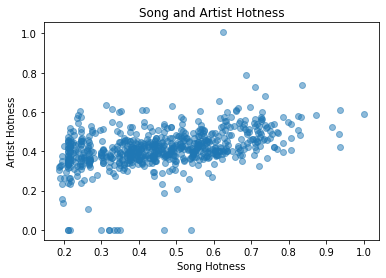

In [15]:
import matplotlib.pyplot as plt
plt.scatter(rdd_song_hotness.collect(), rdd_artist_hotness.collect(), alpha=0.5)
plt.title('Song and Artist Hotness')
plt.xlabel('Song Hotness')
plt.ylabel('Artist Hotness')
plt.show()

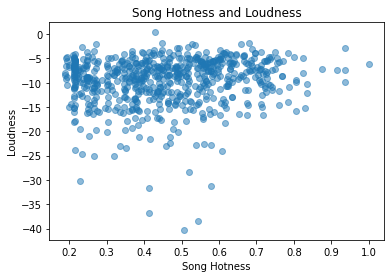

In [16]:
plt.scatter(rdd_song_hotness.collect(), rdd_loudness.collect(), alpha=0.5)
plt.title('Song Hotness and Loudness')
plt.xlabel('Song Hotness')
plt.ylabel('Loudness')
plt.show()

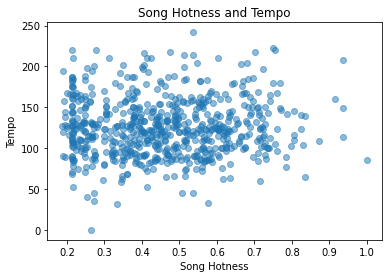

In [17]:
plt.scatter(rdd_song_hotness.collect(), rdd_tempo.collect(), alpha=0.5)
plt.title('Song Hotness and Tempo')
plt.xlabel('Song Hotness')
plt.ylabel('Tempo')
plt.show()

In [ ]:
sc.stop()